# In this notebook I made an gaussian process regression with customized kernel, likelihood and mean function.
Here I approximate the mean function with a $y = ax^2+bx+c$

In [1]:
import pickle as pkl
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary, positive, set_trainable
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow.config.__config__ import default_float, default_int
from gpflow.base import Parameter


set_default_float(np.float64)
set_default_summary_fmt("notebook")

# plt.style.use("ggplot")
%matplotlib inline
np.random.seed(2021)
tf.config.run_functions_eagerly(True)

Input data:

In [2]:
switch_mean = True
    
n_train = 20

calculate the metric of the $\Sigma$3 dataset

In [3]:
# pkl_name = '../../data/symm_angs_engs.pkl'
# jar = open(pkl_name, 'rb')
# s2 = pkl.load(jar,encoding='latin1')
# jar.close()

# Angle = s2['angs']*180/np.pi                 # in radian
# Y0 = s2['engs']                     # eng is mJ/m^2
# cusp_ang = s2['cusps']['angs']      # the angle of cusps in radian 
# cusp_Es = s2['cusps']['engs']       # the energy of cusps in radian
# num_data = len(Angle)

# # Calculates the metric for ground truth data
# metric_arc_gt = np.zeros((num_data, num_data))
# theta_0 = Angle
# for i in range(num_data):
#     theta0 = theta_0[i] - np.floor(theta_0[i]/np.pi)*np.pi
#     for j in range(num_data):
#         theta1 = theta_0[j] - np.floor(theta_0[j]/np.pi)*np.pi
#         metric_arc_gt[i,j] = np.min([np.abs(theta1 - theta0), np.abs(np.pi - theta1 - theta0)])
# np.savetxt('metric_arc_gt.txt', metric_arc_gt)

In [4]:
# theta_test = np.linspace(0, 180, 500)
# # Calculates the metric for test data
# num_data = len(theta_test)
# metric_arc_t = np.zeros((num_data, num_data))
# theta_0 = theta_test
# for i in range(num_data):
#     theta0 = theta_0[i] - np.floor(theta_0[i]/np.pi)*np.pi
#     for j in range(num_data):
#         theta1 = theta_0[j] - np.floor(theta_0[j]/np.pi)*np.pi
#         metric_arc_t[i,j] = np.min([np.abs(theta1 - theta0), np.abs(np.pi - theta1 - theta0)])
# np.savetxt('metric_arc_t.txt', metric_arc_t)

In [3]:
pkl_name = '../../data/symm_angs_engs.pkl'
jar = open(pkl_name, 'rb')
s2 = pkl.load(jar,encoding='latin1')
jar.close()

Angle = s2['angs']*180/np.pi                 # in radian
Y0 = s2['engs']                     # eng is mJ/m^2
cusp_ang = s2['cusps']['angs']      # the angle of cusps in radian 
cusp_Es = s2['cusps']['engs']       # the energy of cusps in radian
theta_test = np.linspace(0, 180, 500)
# all_test = np.hstack((Angle, theta_test))
all_test = Angle
num_data = len(all_test)

metric_arc_all = np.zeros((num_data, num_data))
theta_0 = all_test
for i in range(num_data):
    theta0 = theta_0[i] - np.floor(theta_0[i]/np.pi)*np.pi
    for j in range(num_data):
        theta1 = theta_0[j] - np.floor(theta_0[j]/np.pi)*np.pi
        metric_arc_all[i,j] = np.min([np.abs(theta1 - theta0), np.abs(np.pi - theta1 - theta0)])
np.savetxt('metric_arc_all.txt', metric_arc_all)

In [4]:
rad_cusp_ang = cusp_ang * 180 / np.pi
num_art_test = len(theta_test)
fake_test = np.zeros((num_art_test, 3))
fake_test[:,0] = theta_test
fake_test[:,1] = np.linspace(0, num_art_test - 1, num_art_test) + len(Angle)
for i in range(num_art_test):
    if theta_test[i] <= rad_cusp_ang[1]:
        fake_test[i,2] = 0
    if theta_test[i] > rad_cusp_ang[1]:
        if theta_test[i] <= rad_cusp_ang[2]:
            fake_test[i,2] = 1
    if theta_test[i] > rad_cusp_ang[2]:
        fake_test[i,2] = 2


Define the customized kernel

In [5]:
data_pd = 'metric_arc_all.txt'
def _octonion_dist(X, X2):
    X = tf.reshape(X, [-1,1])
    pd = np.loadtxt(data_pd)
    X2 = tf.reshape(X2, [-1,1])
    dist0 = np.zeros((len(X), len(X2)))
    dist = tf.Variable(dist0) # Use variable 
    for i in range(len(X)):
        init_val = int(X[i].numpy())
        for j in range(len(X2)):
            fin_val = int(X2[j].numpy())
            dist0[i,j] = pd[init_val, fin_val]
    dist.assign(dist0)
    return dist

def _octonion_dist_single(X):
    X = tf.reshape(X, [-1,1])
    pd = np.loadtxt(data_pd)
    dist0 = np.zeros((len(X)))
    dist = tf.Variable(dist0) # Use variable 
    for i in range(len(X)):
        init_val = int(X[i].numpy())

        dist0[i] = pd[init_val, init_val]
    dist.assign(dist0)
    return dist

class GBKernel(gpflow.kernels.Kernel):   
    def __init__(self, variance=1, lengthscales=.5, **kwargs):
        super().__init__(**kwargs)
        self.variance = gpflow.Parameter(variance, transform=positive())
        self.lengthscales = gpflow.Parameter(lengthscales, transform=positive())
        self._validate_ard_active_dims(self.lengthscales)
    
    def K(self, X, X2=None):
        X = X[:,0]
        if X2 is None:
            X2 = X
        else:
            X2 = X2[:,0]
#         a = self.variance * tf.exp(-_octonion_dist(X, X2)/self.lengthscales)
        a = self.variance * tf.exp(-0.5 * _octonion_dist(X, X2)/self.lengthscales)
        tf.debugging.check_numerics(self.lengthscales, 'hi')
        return a

    def K_diag(self, X):
        X = X[:,0]
#         a = self.variance * tf.exp(-_octonion_dist_single(X)/self.lengthscales)
        a = self.variance * tf.exp(-0.5 * _octonion_dist_single(X)/self.lengthscales)
        tf.debugging.check_numerics(self.lengthscales, 'hi')
        return a

Define the multi varince noise in the data points 

In [6]:
class HeteroskedasticGaussian(gpflow.likelihoods.Likelihood):
    def __init__(self, **kwargs):
        # this likelihood expects a single latent function F, and two columns in the data matrix Y:
        super().__init__(latent_dim=1, observation_dim=2, **kwargs)

    def _log_prob(self, F, Y):
        # log_prob is used by the quadrature fallback of variational_expectations and predict_log_density.
        # Because variational_expectations is implemented analytically below, this is not actually needed,
        # but is included for pedagogical purposes.
        # Note that currently relying on the quadrature would fail due to https://github.com/GPflow/GPflow/issues/966
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        return gpflow.logdensities.gaussian(Y, F, NoiseVar)

    def _variational_expectations(self, Fmu, Fvar, Y):
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        Fmu, Fvar = Fmu[:, 0], Fvar[:, 0]
        return (
            -0.5 * np.log(2 * np.pi)
            - 0.5 * tf.math.log(NoiseVar)
            - 0.5 * (tf.math.square(Y - Fmu) + Fvar) / NoiseVar
        )

    # The following two methods are abstract in the base class.
    # They need to be implemented even if not used.

    def _predict_log_density(self, Fmu, Fvar, Y):
        raise NotImplementedError

    def _predict_mean_and_var(self, Fmu, Fvar):
        raise NotImplementedError

Define the customized mean function

In [7]:
from gpflow.config.__config__ import default_float, default_int
from gpflow.base import Parameter

class GB_mean_0(gpflow.mean_functions.MeanFunction):
    """
    y_i = A x_i^2 + B X_i + c
    """
    def __init__(self, A0=None, B0=None, C0=None):
        """
        A is a matrix which maps each element of X to Y, b is an additive
        constant.

        If X has N rows and D columns, and Y is intended to have Q columns,
        then A must be [D, Q], b must be a vector of length Q.
        """
        gpflow.mean_functions.MeanFunction.__init__(self)
        A0 = np.ones((1, 1), dtype=default_float()) if A0 is None else A0
        B0 = np.ones((1, 1), dtype=default_float()) if B0 is None else B0
        C0 = np.zeros(1, dtype=default_float()) if C0 is None else C0
        
        self.A0 = Parameter(np.atleast_2d(A0))
        self.B0 = Parameter(np.atleast_2d(B0))
        self.C0 = Parameter(C0)
        
    def __call__(self, X):
        data0 = "./first_cusp.txt"
        data = np.loadtxt(data0)
        ang = data[:,0].astype(int)
        x_new = X.numpy().astype(int)
        X = ang[x_new].reshape(-1,1)
        X = tf.convert_to_tensor(X, dtype=np.float64)
        
        var_0 = tf.tensordot(tf.math.pow(X, 2), self.A0, [[-1], [0]])
        var_1 = tf.tensordot(X, self.B0, [[-1], [0]])
        var_2 = self.C0
        return var_0 + var_1 + var_2

class GB_mean_1(gpflow.mean_functions.MeanFunction):
    """
    y_i = A x_i + b
    y_i = A x_i^2 + B X_i + c
    """
    def __init__(self, A1=None, B1=None, C1=None):
        """
        A is a matrix which maps each element of X to Y, b is an additive
        constant.

        If X has N rows and D columns, and Y is intended to have Q columns,
        then A must be [D, Q], b must be a vector of length Q.
        """
        gpflow.mean_functions.MeanFunction.__init__(self)
        A1 = np.ones((1, 1), dtype=default_float()) if A1 is None else A1
        B1 = np.ones((1, 1), dtype=default_float()) if B1 is None else B1
        C1 = np.zeros(1, dtype=default_float()) if C1 is None else C1
        
        self.A1 = Parameter(np.atleast_2d(A1))
        self.B1 = Parameter(np.atleast_2d(B1))
        self.C1 = Parameter(C1)
        
    def __call__(self, X):
        data0 = "./first_cusp.txt"
        data = np.loadtxt(data0)
        ang = data[:,0].astype(int)
        x_new = X.numpy().astype(int)
        X = ang[x_new].reshape(-1,1)
        X = tf.convert_to_tensor(X, dtype=np.float64)
        
        var_0 = tf.tensordot(tf.math.pow(X, 2), self.A1, [[-1], [0]])
        var_1 = tf.tensordot(X, self.B1, [[-1], [0]])
        var_2 = self.C1
        return var_0 + var_1 + var_2

class GB_mean_2(gpflow.mean_functions.MeanFunction):
    """
    y_i = A x_i + b
    y_i = A x_i^2 + B X_i + c
    """
    def __init__(self, A2=None, B2=None, C2=None):
        """
        A is a matrix which maps each element of X to Y, b is an additive
        constant.

        If X has N rows and D columns, and Y is intended to have Q columns,
        then A must be [D, Q], b must be a vector of length Q.
        """
        gpflow.mean_functions.MeanFunction.__init__(self)
        A2 = np.ones((1, 1), dtype=default_float()) if A2 is None else A2
        B2 = np.ones((1, 1), dtype=default_float()) if B2 is None else B2
        C2 = np.zeros(1, dtype=default_float()) if C2 is None else C2
        
        self.A2 = Parameter(np.atleast_2d(A2))
        self.B2 = Parameter(np.atleast_2d(B2))
        self.C2 = Parameter(C2)
        
    def __call__(self, X):
        data0 = "./first_cusp.txt"
        data = np.loadtxt(data0)
        ang = data[:,0].astype(int)
        x_new = X.numpy().astype(int)
        X = ang[x_new].reshape(-1,1)
        X = tf.convert_to_tensor(X, dtype=np.float64)
        
        var_0 = tf.tensordot(tf.math.pow(X, 2), self.A2, [[-1], [0]])
        var_1 = tf.tensordot(X, self.B2, [[-1], [0]])
        var_2 = self.C2
        return var_0 + var_1 + var_2

Read the data for [110] symm tilt gbs data

In [8]:
data0 = "./first_cusp.txt"
data = np.loadtxt(data0)
X = data[:, 1:3]
Y = data[:, 3]

mean_y = np.mean(Y)
std_y = np.std(Y)

Y = (Y - mean_y) / std_y
ang = data[:,0].astype(int)

X = X.reshape(-1,2)
Y_all = Y.reshape(-1,1)
# _ = plt.plot(X[:,0], Y, "kx", mew=2)

NoiseVar = np.exp(-((Y_all - 2) ** 2) / 4)/10
NoiseVar = NoiseVar.reshape(-1,1)

N = X.shape[0]
n_train =30

# I chose n_train gbs as training data set randomly
# id_train0 = np.sort(np.random.choice(N, size=n_train, replace=False))
id_train0 = np.floor(np.linspace(0,N-1,n_train))
id_train1 = np.array([0, 29,44,  N-1])
id_train0 = np.concatenate((id_train0, id_train1),axis=0)
id_train0 = np.unique(id_train0).astype(int)
id_train = np.hstack([id_train0.reshape(-1,1), X[id_train0][:,1].reshape(-1, 1)])
Y_train = Y_all[id_train[:,0].astype(int)].reshape(-1,1)
Nois_train = NoiseVar[id_train[:,0].astype(int)].reshape(-1,1)

# # # I chose rest of the gbs as the test set
id_test0 = X[~np.in1d(X[:,0], id_train0)][:,0]
id_test = np.hstack([id_test0.reshape(-1,1), X[id_test0.astype(int)][:,1].reshape(-1, 1)])
Y_test = Y_all[id_test0.astype(int)].reshape(-1,1)
Nois_test = NoiseVar[id_test[:,0].astype(int)].reshape(-1,1)

In [9]:
# adding noise to y values
Y_data = np.hstack([Y_train, Nois_train])
Y_data_test = np.hstack([Y_test, Nois_test])

Text(0, 0.5, 'Energy')

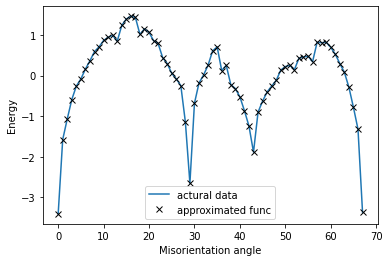

In [10]:
plt.plot(X[:,0], Y_all, label='actural data')
plt.plot(X[:,0], Y_all, "kx",label="approximated func")
plt.legend()
plt.xlabel('Misorientation angle')
plt.ylabel('Energy')

Constructing the model

In [11]:
# model construction
likelihood = HeteroskedasticGaussian()
kernel = GBKernel()
pwl = [GB_mean_0(), GB_mean_1(), GB_mean_2()]
meanf = gpflow.mean_functions.SwitchedMeanFunction(meanfunction_list=pwl)
meanf = None
model = gpflow.models.VGP((id_train, Y_data), kernel=kernel, mean_function=meanf, likelihood=likelihood, num_latent_gps=1)

Optimizing the model

In [12]:
natgrad = NaturalGradient(gamma=1)
adam = tf.optimizers.Adam()

set_trainable(model.q_mu, False)
set_trainable(model.q_sqrt, False)

for _ in range(ci_niter(1000)):
    natgrad.minimize(model.training_loss, [(model.q_mu, model.q_sqrt)])
    adam.minimize(model.training_loss, model.trainable_variables)

Prediction

In [13]:
# apply model on test data set from the gt data
mean_test_gt0, var_test_gt0 = model.predict_f(id_test)
mean_test_gt = mean_test_gt0 * std_y + mean_y

# apply model to the train data set
mean_train_gt0, var_train_gt0 = model.predict_f(id_train)
mean_train_gt = mean_train_gt0 * std_y + mean_y

# # #apply model to the test data set
# mean_fake_test0, var_fake_test0 = model.predict_f(fake_test[:,1:3])
# mean_fake_test = mean_fake_test0 * std_y + mean_y

Y_all_new = Y_all * std_y + mean_y

In [12]:
id_test

array([[ 1.,  0.],
       [ 3.,  0.],
       [ 5.,  0.],
       [ 7.,  0.],
       [ 8.,  0.],
       [10.,  0.],
       [12.,  0.],
       [14.,  0.],
       [15.,  0.],
       [17.,  0.],
       [19.,  0.],
       [21.,  0.],
       [22.,  0.],
       [24.,  0.],
       [26.,  0.],
       [28.,  0.],
       [31.,  1.],
       [33.,  1.],
       [35.,  1.],
       [37.,  1.],
       [38.,  1.],
       [40.,  1.],
       [42.,  1.],
       [45.,  2.],
       [47.,  2.],
       [49.,  2.],
       [51.,  2.],
       [52.,  2.],
       [54.,  2.],
       [56.,  2.],
       [58.,  2.],
       [59.,  2.],
       [61.,  2.],
       [63.,  2.],
       [65.,  2.],
       [66.,  2.]])

Plot the predicted-actual graph

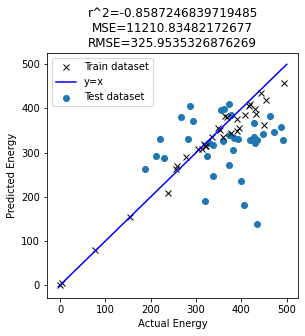

In [14]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_all_new[id_test[:,0].astype(int)], mean_test_gt.numpy())

import math
rmse = math.sqrt(mean_squared_error(Y_all[id_test[:,0].astype(int)], mean_test_gt.numpy()))


x = np.linspace(-3.5, 500,100)
plt.figure(figsize=(4.5, 4.5))

plt.scatter(Y_all_new[id_test[:,0].astype(int)], mean_test_gt,label="Test dataset")
plt.plot(Y_all_new[id_train[:,0].astype(int)], mean_train_gt, 'kx', label="Train dataset")
plt.plot(x, x,'b', label='y=x')
plt.legend()
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
from sklearn.metrics import r2_score
r2 = r2_score(Y_all_new[id_test[:,0].astype(int)], mean_test_gt)
plt.title('r^2='+str(r2) + '\n' + 'MSE=' + str(mse) + '\n' + 'RMSE=' + str(rmse))
plt.savefig('AP_withopt.jpg')

In [35]:
Y0.max()

492.658555634302

Text(0, 0.5, 'Energy')

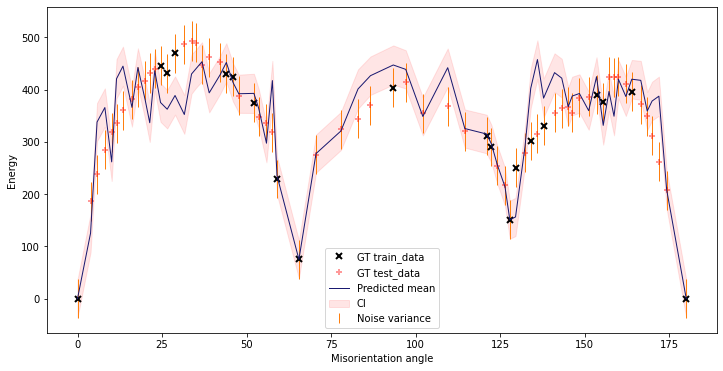

In [46]:
mean_all0, var_all0 = model.predict_f(X)
mean_all = mean_all0 * std_y + mean_y
Y_all = Y0 
var_all = var_all0 * std_y + mean_y
NoiseVar = NoiseVar *std_y + mean_y
plt.figure(figsize=(12, 6))
plt.plot(Angle[id_train[:,0].astype(int)].reshape(-1), Y_all[id_train[:,0].astype(int)], "kx", mew=2, label="GT train_data")
plt.plot(Angle[id_test[:,0].astype(int)].reshape(-1), Y_all[id_test[:,0].astype(int)], "r+", mew=2, alpha=.4, label="GT test_data")
plt.plot(Angle.reshape(-1), mean_all.numpy(),'midnightblue', lw=1, label="Predicted mean")

ang_plt = Angle[:,0]
y1 = mean_all[:, 0] - 1.96 * np.sqrt(var_all[:, 0])
y2 = mean_all[:, 0] + 1.96 * np.sqrt(var_all[:, 0])
plt.fill_between(
    ang_plt,
    y1.numpy(),
    y2.numpy(),
    color="r",
    alpha=0.1,
    label='CI'
)
plt.errorbar(
    Angle,
    Y_all,
    yerr=2 * (np.sqrt(NoiseVar)).squeeze(),
#     marker="x",
    lw=0,
    elinewidth=1.0,
    color="C1",
    label='Noise variance'
)
# _ = plt.xlim(-.1, 3.4)
plt.legend()
# plt.title('Random train data set')
plt.xlabel('Misorientation angle')
plt.ylabel('Energy')

Text(0, 0.5, 'Residual')

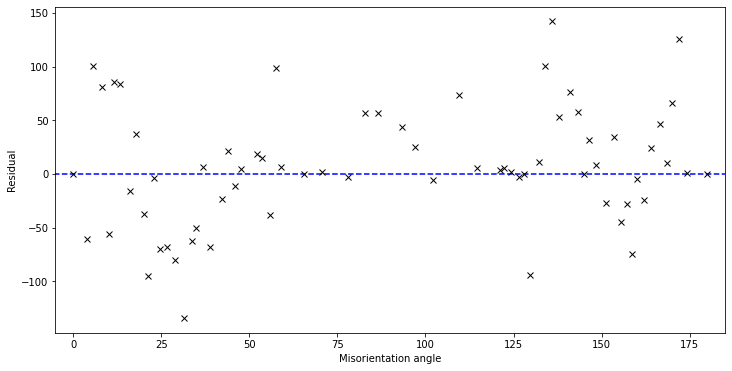

In [45]:
plt.figure(figsize=(12, 6))
res = mean_all - Y0.reshape(-1,1)
plt.plot(Angle, res, 'kx')
plt.hlines(y=0, xmin=-10, xmax=191, color='b', linestyles='dashed')
_ = plt.xlim(-5, 185)
plt.xlabel('Misorientation angle')
plt.ylabel('Residual')

In [42]:
mean_all[1:10]

<tf.Tensor: shape=(9, 1), dtype=float64, numpy=
array([[125.25947352],
       [337.90016783],
       [365.5577293 ],
       [261.58550096],
       [420.58031455],
       [444.73549919],
       [365.89058199],
       [442.19188767],
       [378.79811488]])>

In [44]:
Y0.shape

(68,)